In [1]:
import sys; sys.path.insert(1, '/home/vinicius/storage1/projects/GrayData-Analysis')
import os

import numpy  as np 
import xarray as xr

import matplotlib.pyplot  as plt
import GDa.graphics.plot  as plot
import matplotlib.patches as patches
import matplotlib

from   GDa.session           import session_info, session
from   GDa.signal.surrogates import trial_swap_surrogates, phase_rand_surrogates

from xfrites.conn.conn_spec  import conn_spec

In [2]:
SMALL_SIZE, MEDIUM_SIZE, BIGGER_SIZE=plot.set_plot_config()

#### Loading data

In [3]:
# Instantiate class
ses = session(raw_path = '../GrayLab/', monkey = 'lucy', date = '141017', session = 1,
              slvr_msmod = False, align_to = 'cue', evt_dt = [-0.65, 3.00])

# Read data from .mat files
ses.read_from_mat()

# Filtering by trials
data = ses.filter_trials(trial_type=[1],behavioral_response=[1]).isel(trials=slice(0,20))

In [4]:
#### Surrogate data
n_surr    = 20
data_surr = []
for i in range(n_surr): data_surr += [phase_rand_surrogates(data, seed=i*200, verbose=False, n_jobs=1)]#[trial_swap_surrogates(data, seed = i*200, verbose=False)]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

  0%|          |  : 0/20 [00:00<?,       ?it/s]

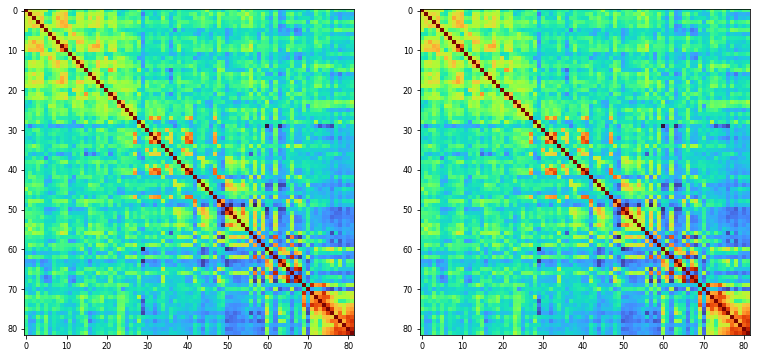

In [11]:
plt.figure(figsize=(13,6))
plt.subplot(1,2,1)
plt.imshow( np.corrcoef(data[15]), aspect="auto", cmap="turbo" )
plt.subplot(1,2,2)
plt.imshow( np.corrcoef(data_surr[0][15]), aspect="auto", cmap="turbo" )

#### Choosing pair of regions

These channel pairs display spectral peaks and strong coherence in Band 2. There are 2 short distance pairs (12-17, 17-18) and 1 long distance pair (17-181).

- 12 vs 17
- 17 vs 18
- 17 vs 181

These channel pairs display spectral peaks and strong coherence in Band 4. Both pairs are median distance examples.

- 69 vs 104
- 96 vs 106

In [12]:
channel_labels = np.array([12, 17, 18, 181, 69,104,95,106])

In [13]:
channel_indexes = []
for c in channel_labels:
    channel_indexes += [np.where( data.attrs["channels_labels"]==c )[0][0]]

In [14]:
print(f"{channel_indexes=}")

channel_indexes=[6, 11, 12, 65, 30, 39, 36, 41]


In [15]:
pairs = np.array([[6,11],
                  [11,12],
                  [11,65],
                  [30,39],
                  [36,41]])

### Spectral analysis

#### Define parameters

In [16]:
# Smoothing windows

#sm_times  = 0.3
sm_freqs  = 1
sm_kernel = "square"
decim     = 15

# Defining parameters
mode  = 'morlet' # ("morlet", "mt_1", "mt_2")
foi   = np.array([
        [.1, 6.],
        [6., 14.],
        [14., 26.],
        [26., 42.],
        [42., 80.]
            ])

n_freqs  = 50
freqs    = np.linspace(foi[0,0], foi[-1,1], n_freqs, endpoint=True)

n_cycles  = freqs/2
sm_times  = 0.3

In [17]:
kw = dict(
    freqs=freqs, times="time", roi="roi", foi=None, n_jobs=20, pairs=pairs,
    mode=mode, n_cycles=n_cycles, decim=decim, metric="coh", sm_kernel=sm_kernel,
    sm_times=sm_times, sm_freqs=sm_freqs, block_size=1, 
)

# compute the coherence
coh = conn_spec(data, **kw)

Computing pairwise Coherence (n_pairs=5, n_freqs=50, decim=15, sm_times=20, sm_freqs=1)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  52 tasks      | elapsed:    1.8s
[Parallel(n_jobs=20)]: Done  80 out of  82 | elapsed:    2.1s remaining:    0.1s
[Parallel(n_jobs=20)]: Done  82 out of  82 | elapsed:    2.1s finished


  0%|          | Estimating pairwise Coherence for trials 0...19 : 0/5 [00:00<?,       ?it/s]

In [18]:
# compute the coherence for each surrogate
coh_surr = []
for i in range(n_surr): coh_surr += [conn_spec(data_surr[i], **kw)]

Computing pairwise Coherence (n_pairs=5, n_freqs=50, decim=15, sm_times=20, sm_freqs=1)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  52 tasks      | elapsed:    1.8s
[Parallel(n_jobs=20)]: Done  80 out of  82 | elapsed:    2.1s remaining:    0.1s
[Parallel(n_jobs=20)]: Done  82 out of  82 | elapsed:    2.1s finished


  0%|          | Estimating pairwise Coherence for trials 0...19 : 0/5 [00:00<?,       ?it/s]

Computing pairwise Coherence (n_pairs=5, n_freqs=50, decim=15, sm_times=20, sm_freqs=1)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  52 tasks      | elapsed:    2.0s
[Parallel(n_jobs=20)]: Done  80 out of  82 | elapsed:    2.3s remaining:    0.1s
[Parallel(n_jobs=20)]: Done  82 out of  82 | elapsed:    2.3s finished


  0%|          | Estimating pairwise Coherence for trials 0...19 : 0/5 [00:00<?,       ?it/s]

Computing pairwise Coherence (n_pairs=5, n_freqs=50, decim=15, sm_times=20, sm_freqs=1)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  52 tasks      | elapsed:    1.9s
[Parallel(n_jobs=20)]: Done  80 out of  82 | elapsed:    2.3s remaining:    0.1s
[Parallel(n_jobs=20)]: Done  82 out of  82 | elapsed:    2.3s finished


  0%|          | Estimating pairwise Coherence for trials 0...19 : 0/5 [00:00<?,       ?it/s]

Computing pairwise Coherence (n_pairs=5, n_freqs=50, decim=15, sm_times=20, sm_freqs=1)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  52 tasks      | elapsed:    1.9s
[Parallel(n_jobs=20)]: Done  80 out of  82 | elapsed:    2.2s remaining:    0.1s
[Parallel(n_jobs=20)]: Done  82 out of  82 | elapsed:    2.2s finished


  0%|          | Estimating pairwise Coherence for trials 0...19 : 0/5 [00:00<?,       ?it/s]

Computing pairwise Coherence (n_pairs=5, n_freqs=50, decim=15, sm_times=20, sm_freqs=1)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  52 tasks      | elapsed:    1.9s
[Parallel(n_jobs=20)]: Done  80 out of  82 | elapsed:    2.2s remaining:    0.1s
[Parallel(n_jobs=20)]: Done  82 out of  82 | elapsed:    2.2s finished


  0%|          | Estimating pairwise Coherence for trials 0...19 : 0/5 [00:00<?,       ?it/s]

Computing pairwise Coherence (n_pairs=5, n_freqs=50, decim=15, sm_times=20, sm_freqs=1)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  52 tasks      | elapsed:    1.9s
[Parallel(n_jobs=20)]: Done  80 out of  82 | elapsed:    2.1s remaining:    0.1s
[Parallel(n_jobs=20)]: Done  82 out of  82 | elapsed:    2.1s finished


  0%|          | Estimating pairwise Coherence for trials 0...19 : 0/5 [00:00<?,       ?it/s]

Computing pairwise Coherence (n_pairs=5, n_freqs=50, decim=15, sm_times=20, sm_freqs=1)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  52 tasks      | elapsed:    2.0s
[Parallel(n_jobs=20)]: Done  80 out of  82 | elapsed:    2.2s remaining:    0.1s
[Parallel(n_jobs=20)]: Done  82 out of  82 | elapsed:    2.3s finished


  0%|          | Estimating pairwise Coherence for trials 0...19 : 0/5 [00:00<?,       ?it/s]

Computing pairwise Coherence (n_pairs=5, n_freqs=50, decim=15, sm_times=20, sm_freqs=1)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  52 tasks      | elapsed:    2.0s
[Parallel(n_jobs=20)]: Done  80 out of  82 | elapsed:    2.3s remaining:    0.1s
[Parallel(n_jobs=20)]: Done  82 out of  82 | elapsed:    2.3s finished


  0%|          | Estimating pairwise Coherence for trials 0...19 : 0/5 [00:00<?,       ?it/s]

Computing pairwise Coherence (n_pairs=5, n_freqs=50, decim=15, sm_times=20, sm_freqs=1)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  52 tasks      | elapsed:    2.0s
[Parallel(n_jobs=20)]: Done  80 out of  82 | elapsed:    2.3s remaining:    0.1s
[Parallel(n_jobs=20)]: Done  82 out of  82 | elapsed:    2.4s finished


  0%|          | Estimating pairwise Coherence for trials 0...19 : 0/5 [00:00<?,       ?it/s]

Computing pairwise Coherence (n_pairs=5, n_freqs=50, decim=15, sm_times=20, sm_freqs=1)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  52 tasks      | elapsed:    2.0s
[Parallel(n_jobs=20)]: Done  80 out of  82 | elapsed:    2.3s remaining:    0.1s
[Parallel(n_jobs=20)]: Done  82 out of  82 | elapsed:    2.3s finished


  0%|          | Estimating pairwise Coherence for trials 0...19 : 0/5 [00:00<?,       ?it/s]

Computing pairwise Coherence (n_pairs=5, n_freqs=50, decim=15, sm_times=20, sm_freqs=1)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  52 tasks      | elapsed:    2.0s
[Parallel(n_jobs=20)]: Done  80 out of  82 | elapsed:    2.2s remaining:    0.1s
[Parallel(n_jobs=20)]: Done  82 out of  82 | elapsed:    2.3s finished


  0%|          | Estimating pairwise Coherence for trials 0...19 : 0/5 [00:00<?,       ?it/s]

Computing pairwise Coherence (n_pairs=5, n_freqs=50, decim=15, sm_times=20, sm_freqs=1)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  52 tasks      | elapsed:    2.0s
[Parallel(n_jobs=20)]: Done  80 out of  82 | elapsed:    2.2s remaining:    0.1s
[Parallel(n_jobs=20)]: Done  82 out of  82 | elapsed:    2.3s finished


  0%|          | Estimating pairwise Coherence for trials 0...19 : 0/5 [00:00<?,       ?it/s]

Computing pairwise Coherence (n_pairs=5, n_freqs=50, decim=15, sm_times=20, sm_freqs=1)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  52 tasks      | elapsed:    2.0s
[Parallel(n_jobs=20)]: Done  80 out of  82 | elapsed:    2.4s remaining:    0.1s
[Parallel(n_jobs=20)]: Done  82 out of  82 | elapsed:    2.4s finished


  0%|          | Estimating pairwise Coherence for trials 0...19 : 0/5 [00:00<?,       ?it/s]

Computing pairwise Coherence (n_pairs=5, n_freqs=50, decim=15, sm_times=20, sm_freqs=1)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  52 tasks      | elapsed:    2.1s
[Parallel(n_jobs=20)]: Done  80 out of  82 | elapsed:    2.4s remaining:    0.1s
[Parallel(n_jobs=20)]: Done  82 out of  82 | elapsed:    2.5s finished


  0%|          | Estimating pairwise Coherence for trials 0...19 : 0/5 [00:00<?,       ?it/s]

Computing pairwise Coherence (n_pairs=5, n_freqs=50, decim=15, sm_times=20, sm_freqs=1)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  52 tasks      | elapsed:    1.9s
[Parallel(n_jobs=20)]: Done  80 out of  82 | elapsed:    2.2s remaining:    0.1s
[Parallel(n_jobs=20)]: Done  82 out of  82 | elapsed:    2.2s finished


  0%|          | Estimating pairwise Coherence for trials 0...19 : 0/5 [00:00<?,       ?it/s]

Computing pairwise Coherence (n_pairs=5, n_freqs=50, decim=15, sm_times=20, sm_freqs=1)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  52 tasks      | elapsed:    2.0s
[Parallel(n_jobs=20)]: Done  80 out of  82 | elapsed:    2.3s remaining:    0.1s
[Parallel(n_jobs=20)]: Done  82 out of  82 | elapsed:    2.3s finished


  0%|          | Estimating pairwise Coherence for trials 0...19 : 0/5 [00:00<?,       ?it/s]

Computing pairwise Coherence (n_pairs=5, n_freqs=50, decim=15, sm_times=20, sm_freqs=1)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  52 tasks      | elapsed:    2.0s
[Parallel(n_jobs=20)]: Done  80 out of  82 | elapsed:    2.3s remaining:    0.1s
[Parallel(n_jobs=20)]: Done  82 out of  82 | elapsed:    2.4s finished


  0%|          | Estimating pairwise Coherence for trials 0...19 : 0/5 [00:00<?,       ?it/s]

Computing pairwise Coherence (n_pairs=5, n_freqs=50, decim=15, sm_times=20, sm_freqs=1)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  52 tasks      | elapsed:    1.9s
[Parallel(n_jobs=20)]: Done  80 out of  82 | elapsed:    2.2s remaining:    0.1s
[Parallel(n_jobs=20)]: Done  82 out of  82 | elapsed:    2.2s finished


  0%|          | Estimating pairwise Coherence for trials 0...19 : 0/5 [00:00<?,       ?it/s]

Computing pairwise Coherence (n_pairs=5, n_freqs=50, decim=15, sm_times=20, sm_freqs=1)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  52 tasks      | elapsed:    2.0s
[Parallel(n_jobs=20)]: Done  80 out of  82 | elapsed:    2.2s remaining:    0.1s
[Parallel(n_jobs=20)]: Done  82 out of  82 | elapsed:    2.3s finished


  0%|          | Estimating pairwise Coherence for trials 0...19 : 0/5 [00:00<?,       ?it/s]

Computing pairwise Coherence (n_pairs=5, n_freqs=50, decim=15, sm_times=20, sm_freqs=1)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  52 tasks      | elapsed:    2.0s
[Parallel(n_jobs=20)]: Done  80 out of  82 | elapsed:    2.4s remaining:    0.1s
[Parallel(n_jobs=20)]: Done  82 out of  82 | elapsed:    2.4s finished


  0%|          | Estimating pairwise Coherence for trials 0...19 : 0/5 [00:00<?,       ?it/s]

In [49]:
coh_surr = xr.concat(coh_surr, dim="seeds")

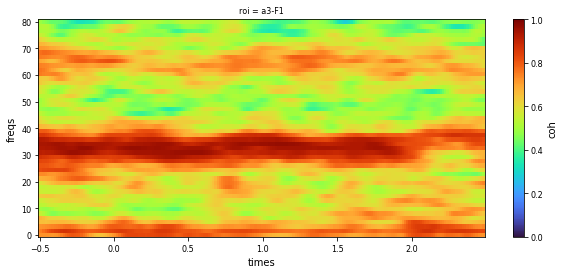

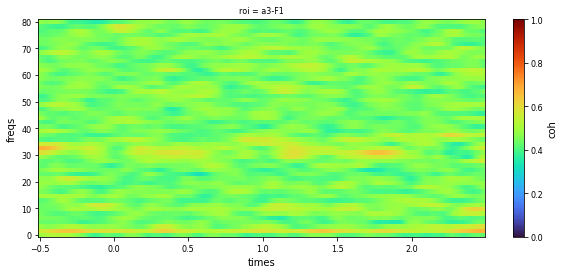

In [60]:
plt.figure(figsize=(10,4))
coh.mean("trials").isel(roi=4).sel(times=slice(-0.5,2.5)).plot(x="times", y="freqs", cmap="turbo", vmin=0, vmax=1);
plt.figure(figsize=(10,4))
coh_surr.mean(dim=("trials","seeds")).sel(times=slice(-0.5,2.5)).isel(roi=4).plot(x="times", y="freqs", cmap="turbo", vmin=0, vmax=1);

No handles with labels found to put in legend.
No handles with labels found to put in legend.


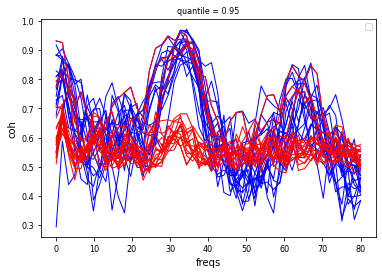

In [62]:
coh.isel(roi=4).sel(times=slice(-0.5,2.5)).mean("times").plot(x="freqs", hue="trials", lw=1, color="b");
plt.legend();
coh_surr.isel(roi=4).sel(times=slice(-0.5,2.5)).mean("times").quantile(0.95, "seeds").plot(x="freqs", hue="trials", lw=1, color="r");
plt.legend();

In [65]:
thr = coh_surr.quantile(0.95, "seeds")

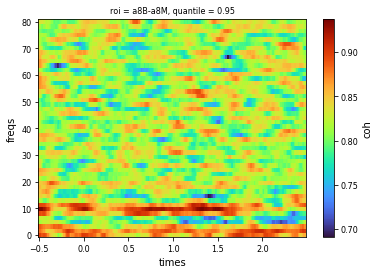

In [68]:
thr.mean("trials").sel(times=slice(-0.5,2.5)).isel(roi=0).plot(x="times", y="freqs", cmap="turbo")

In [73]:
aux = (coh>=thr)*coh

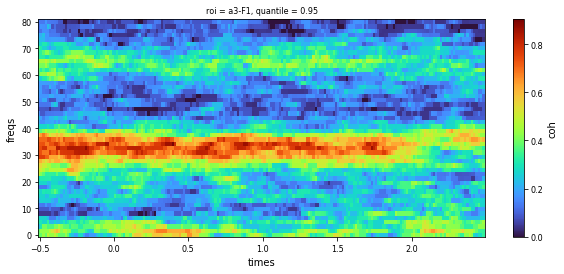

In [78]:
plt.figure(figsize=(10,4))
aux.mean("trials").isel(roi=4).sel(times=slice(-0.5,2.5)).plot(x="times", y="freqs", cmap="turbo");

No handles with labels found to put in legend.


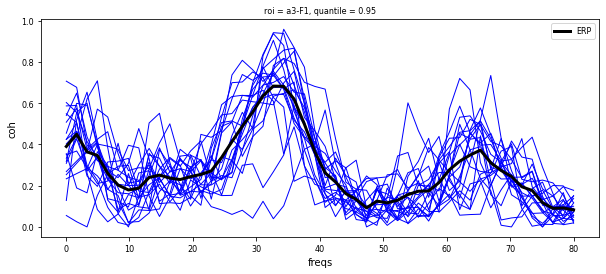

In [92]:
plt.figure(figsize=(10,4))
aux.isel(roi=4).sel(times=slice(-0.5,2.5)).mean("times").plot(x="freqs", hue="trials", lw=1, color="b");
plt.legend()
aux.isel(roi=4).sel(times=slice(-0.5,2.5)).mean("times").mean("trials").plot(x="freqs", hue="trials", lw=3, color="k", label="ERP");
plt.legend()